In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy import stats

g_norm = 1.0/np.sqrt(2*np.pi)

In [2]:
def uncertainties(ys,patch=False):
    # find uncertainties (simply sqrt of entries)
    # - for fitting a 0 uncertainty does not work so we set it to 1000 to avoid chi2 contribution
    sigmas = np.sqrt(ys)
    for i in range(0,len(sigmas)): # if there are zero entries we get division by zero!
        if sigmas[i] == 0 and patch:
            sigmas[i] = 1000
    return sigmas

In [3]:
def straight_mean_var(data):
    # mean and variance from the raw data
    mean_raw = np.mean(data)
    var_raw = np.var(data)
    print("\n-- No fit")
    print(" Nevents:  %d"%(len(data)))
    print(" Mean:     %f +- %f"%(np.mean(data),np.sqrt(np.var(data)/len(data))))
    print(" Variance: %f"%(np.var(data)))
    print(" Width:    %f"%(np.sqrt(np.var(data))))
    
    return mean_raw,var_raw

In [4]:
def gaussian(x, amplitude, mean, width):
    # Gaussian function, including a variable normalization, ready for your histogram fit

    return amplitude*g_norm/width * np.exp(-0.5*((x-mean)/width)**2)

In [5]:
def fit_gaussian_without(xs,ys):
    # implement a set of histogram fits
    
    x_array = np.array(xs)
    y_array = np.array(ys)

    # fit without uncertainties
    pname = ['Amplitude', 'Mean', 'Width']
    par, pcov = curve_fit(gaussian, x_array, y_array, p0=(500, 10, 2))
    print("\n== Fit without including uncertainties")
    for i in range(0,3):
        print(" P(%9s,%d): %f +- %f"%(pname[i],i,par[i],np.sqrt(pcov[i][i])))

    return par, pcov

In [6]:
def fit_gaussian(xs,ys):
    # implement a set of histogram fits
    
    x_array = np.array(xs)
    y_array = np.array(ys)

    # find uncertainties (simply sqrt of entries)
    sigmas = uncertainties(y_array,True) # patch uncertainties of 0
    
    # fit with uncertainties
    print("\n== Fit including uncertainties")
    pname = ['Amplitude', 'Mean', 'Width']
    par, pcov = curve_fit(gaussian, x_array, y_array, p0=(500, 10, 2), sigma=sigmas)
    for i in range(0,3):
        print(" P(%9s,%d): %f +- %f"%(pname[i],i,par[i],np.sqrt(pcov[i][i])))

    chi2,ndof = chi2_ndof(gaussian, par, x_array, y_array, sigmas)
    prob = probability(chi2,ndof)
    print(" Chi2: %f,  Ndof: %d"%(chi2,ndof))
    print(" Prob: %f"%(prob))
        
    return par, pcov, prob

In [7]:
def chi2_ndof(gaussian, par, x_array, y_array, sigma):
    chi2 = 0.
    ndof = len(par) * (-1.)
    for x,y,sig in zip(x_array,y_array,sigma):
        prediction = gaussian(x,par[0],par[1],par[2])
        #print(" x: %f,  y: %f,  sig: %f, -- prediction: %f"%(x,y,sig,prediction))
        if sig>0: # make sure we do not divide by zero
            dChi2 = (y-prediction)*(y-prediction)/sig/sig
            chi2 += dChi2
            ndof += 1
            #print("dChi2: %f"%(dChi2))
        else:
            print("WARNING - sigma=0: x: %f,  y: %f,  sig: %f, -- prediction: %f"%(x,y,sig,prediction))
    return chi2, ndof

In [8]:
def probability(chi2,ndof):
    return (1.0 - stats.chi2.cdf(chi2,ndof))


-- No fit
 Nevents:  500
 Mean:     19.957215 +- 0.111570
 Variance: 6.223909
 Width:    2.494776


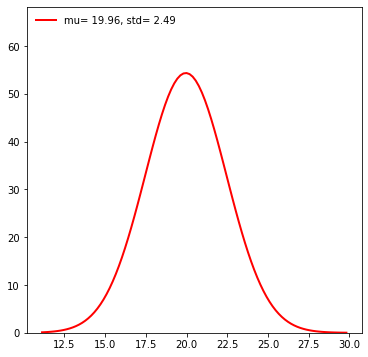

In [9]:
# parameters
name = 'fit'
xtitle = 'Default Fit x title'
ytitle = 'Default Fit y title'

n_events = 500

# generate some data for this demonstration.
data = norm.rvs(20.0, 2.5, size=n_events)

# calculate variables
mean_raw,var_raw = straight_mean_var(data)

# define the figure
fig = plt.figure(name,figsize=(6,6))
#ns, bins, patches = plt.hist(data, 25, histtype = 'step', linewidth=2)
ns, bins, patches = plt.hist(data, 25, histtype = 'step',color='w',alpha=.01)
#ns, bins, patches = plt.hist(data, 25)

# careful bin width matters for integral
binwidth = bins[1]-bins[0]
normalize = n_events * binwidth

# plot the prediction on top
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = normalize * norm.pdf(x, mean_raw, np.sqrt(var_raw)) # make sure to normalize correctly
label = "mu= %.2f, std= %.2f" % (mean_raw, np.sqrt(var_raw))
plt.plot(x, p, 'r', linewidth=2, label=label)
# legend
leg = plt.legend(loc="upper left",frameon=False)

# prepare data for the least chi2 binned fit
xs = []
ys = []
for n,bmin in zip(ns,bins[:-1]):
    xs.append(bmin+0.5*binwidth)
    ys.append(n)

In [10]:
# now fit the data
fit_gaussian_without(xs,ys)
par,pcov,prob = fit_gaussian(xs,ys)


== Fit without including uncertainties
 P(Amplitude,0): 339.916383 +- 13.038323
 P(     Mean,1): 19.821693 +- 0.110753
 P(    Width,2): 2.500904 +- 0.110800

== Fit including uncertainties
 P(Amplitude,0): 324.186292 +- 15.536349
 P(     Mean,1): 19.862651 +- 0.115994
 P(    Width,2): 2.384380 +- 0.087223
 Chi2: 24.044091,  Ndof: 22
 Prob: 0.344922


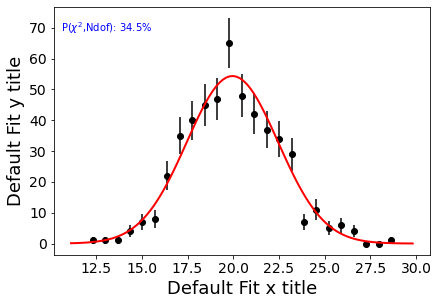

In [11]:
ax = plt.gca()

# make a marker plot
sigmas = uncertainties(ys)
plt.scatter(xs, ys, label=label,color='black')      # markers
plt.errorbar(xs,ys,yerr=sigmas,color='black',ls='none')   # error bars
plt.plot(x, p, 'r', linewidth=2, label=label)
plt.text(0.02,0.90,r'P($\chi^2$,Ndof): %4.1f%%'%(prob*100),{'color': 'b'}, transform=ax.transAxes)

# make plot nicer
plt.xlabel(xtitle, fontsize=18)
plt.ylabel(ytitle, fontsize=18)

# make axis tick numbers larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# make sure to noe have too much white space around the plot
plt.subplots_adjust(top=0.99, right=0.99, bottom=0.13, left=0.12)

# save plot for later viewing
plt.savefig("../png/"+name+".png",bbox_inches='tight',dpi=400)

# show the plot for interactive use
plt.show()